In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import numpy as np

import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
from torchsummary import summary

In [3]:
if torch.cuda.is_available():
    torch_device = 'cuda'
else:
    torch_device = 'cpu'
print(f"TORCH DEVICE: {torch_device}")

TORCH DEVICE: cuda


# Dataset

Come dataset, usiamo il CIFAIR10, un dataset di immagini divise in 10 classi.

In [4]:
transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                transforms.RandomCrop(32, padding=4),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)



  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


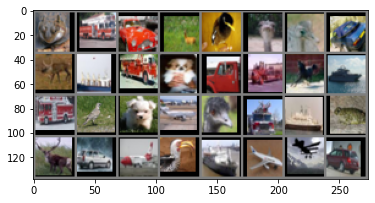

In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
#print(' '.join(f'{classes[labels[j]]:5s}' for j in range(64)))

#Reti Convoluzionali


Nelle reti convoluzionali in prodotto matriciale delle fully-connected viene sostituito da una convoluzione:
$$\hat{y}=\sigma(X\ast K)$$
dove la convoluzione è definita come:
$$(X\ast K)_{i,j}=\sum_{n,m=-∞}^{∞}X(m,n)K(m-i,n-j)$$

Un filtro o kernel convoluzionale è una matrice di numeri che viene applicata ad una porzione dell'immagine di input per produrre un singolo valore di output. Questo valore di output è calcolato attraverso una somma pesata dei valori dei pixel dell'immagine coperti dal filtro, dove i pesi sono i valori della matrice del filtro. L'intero filtro viene poi applicato a tutti i possibili "punti" dell'immagine di input, producendo una nuova immagine o "rappresentazione". In questo modo, i filtri convoluzionali sono in grado di individuare pattern come bordi, curve, texture e oggetti all'interno dell'immagine.

Immagine presa da: https://github.com/vdumoulin/conv_arithmetic

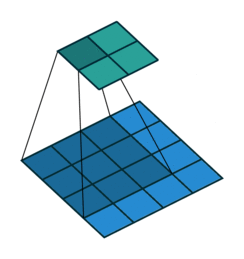

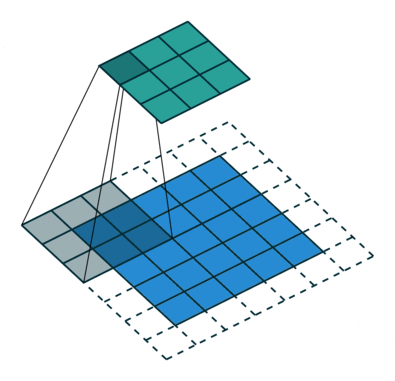

Dimensione della rappresentazione in output:
$$ O = \frac{I-F+2P}{S}+1 $$

dove:

* "I" rappresenta la dimensione dell'input (in altezza o larghezza);
* "F" rappresenta la dimensione del filtro (in altezza o larghezza);
* "P" rappresenta lo zero padding, ovvero il numero di zeri aggiunti ai bordi dell'input per mantenere la dimensione dell'output;
* "S" rappresenta lo stride, ovvero quanti pixel che caratterizzano il passo del compiuto dal kernel tra due applicazioni;
* "O" rappresenta la dimensione dell'output (in altezza o larghezza).



Il **pooling** è una tecnica utilizzata nelle reti convoluzionali per ridurre la dimensione delle rappresentazioni prodotte dai layer convoluzionali. In particolare, il pooling divide l'immagine di input in regioni non sovrapposte e, per ogni regione, ne calcola il massimo (max pooling) o la media (average pooling). 

Il layer di **dropout** è una tecnica utilizzata nelle reti neurali per prevenire l'overfitting. In pratica, durante l'addestramento della rete, il layer di dropout seleziona casualmente un certo numero di neuroni e li "disattiva" temporaneamente. Ciò fa sì che la rete diventi più robusta in quanto i neuroni rimanenti devono imparare a gestire le informazioni anche in assenza dei neuroni disattivati. 

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # 3 canali di input, 6 filtri da 5x5
        #torch.nn.init.xavier_uniform(self.conv1.weight) #inizializzazione
        self.pool = nn.MaxPool2d(2, 2)   # pooling di 2x2
        self.conv2 = nn.Conv2d(6, 16, 5) # 6 canali di input, 16 filtri da 5x5
        self.fc1 = nn.Linear(16 * 5 * 5, 100)  # fully connected layer con 100 unità
        self.fc2 = nn.Linear(100, 10)    # fully connected layer con 10 unità (una per ogni classe)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # convoluzione, attivazione ReLU e max pooling
        x = self.pool(F.relu(self.conv2(x)))  # convoluzione, attivazione ReLU e max pooling
        x = x.view(-1, 16 * 5 * 5)  # appiattimento per il fully connected layer
        x = F.relu(self.fc1(x))     # fully connected layer con attivazione ReLU
        x = self.fc2(x)             # fully connected layer finale
        return x

nn (3).svg

In [7]:
def train(epoch,net,optimizer,criterion):
    for epoch in tqdm(range(epoch)):  # addestramento per 2 epoche
        train_loss = 0
        correct_train = 0
        total_train = 0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs.to(torch_device))
            loss = criterion(outputs, labels.to(torch_device))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted_train = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += predicted_train.eq(labels.to(torch_device)).cpu().sum().item()

        train_accuracy = 100 * correct_train / total_train
        print('Epoch %d, train loss: %.3f, train accuracy: %.2f%%' %
              (epoch + 1, train_loss / len(train_loader), train_accuracy))
        
    print('Finished Training')

In [8]:
def evaluate_accuracy(model, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = model(images.to(torch_device))
            _, predicted = torch.max(outputs.data, 1)  
            total += labels.size(0) 
            correct += (predicted == labels.to(torch_device)).sum().item() 
    accuracy = 100 * correct / total  
    return accuracy

def accuracy_classes(net,dataloader,classes): 
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = net(images.to(torch_device))
            _, predictions = torch.max(outputs, 1)
            for label, prediction in zip(labels.to(torch_device), predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

In [9]:
net = Net().to(torch_device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
epoch=10

In [10]:
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 100]          40,100
            Linear-6                   [-1, 10]           1,010
Total params: 43,982
Trainable params: 43,982
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.17
Estimated Total Size (MB): 0.24
----------------------------------------------------------------


In [11]:
train(epoch,net,optimizer,criterion)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, train loss: 1.688, train accuracy: 37.88%
Epoch 2, train loss: 1.478, train accuracy: 46.21%
Epoch 3, train loss: 1.395, train accuracy: 49.78%
Epoch 4, train loss: 1.338, train accuracy: 51.81%
Epoch 5, train loss: 1.292, train accuracy: 53.62%
Epoch 6, train loss: 1.255, train accuracy: 54.97%
Epoch 7, train loss: 1.225, train accuracy: 56.06%
Epoch 8, train loss: 1.197, train accuracy: 57.03%
Epoch 9, train loss: 1.184, train accuracy: 57.91%
Epoch 10, train loss: 1.164, train accuracy: 58.79%
Finished Training


In [12]:
evaluate_accuracy(net,test_loader)

58.91

In [13]:
accuracy_classes(net,test_loader,classes)

Accuracy for class: plane is 60.4 %
Accuracy for class: car   is 67.6 %
Accuracy for class: bird  is 44.9 %
Accuracy for class: cat   is 35.9 %
Accuracy for class: deer  is 55.0 %
Accuracy for class: dog   is 60.0 %
Accuracy for class: frog  is 67.3 %
Accuracy for class: horse is 64.0 %
Accuracy for class: ship  is 69.9 %
Accuracy for class: truck is 64.1 %


#Residual CNN

Il problema dei gradienti che scompaiono o esplodono (**vanishing/exploding gradients**) si verifica quando i gradienti calcolati durante la backpropagation diventano troppo piccoli o troppo grandi man mano che si procede attraverso i layer della rete. Ciò rende difficile o addirittura impossibile aggiornare i pesi dei layer più profondi, poiché i gradienti diventano troppo piccoli per produrre un effetto significativo sull'aggiornamento dei pesi, oppure troppo grandi, causando oscillazioni incontrollate nei pesi e una convergenza lenta o assente durante l'addestramento. 

Le **connessioni residue** sommano l'input di un layer all'output. In formule:
$$output=\mathcal{F}(x)+x$$
dove $x$ rappresenta l'input grezzo del layer corrente e $\mathcal{F}(x)$ rappresenta l'output dell'operazione di convoluzione e/o pooling. 

La **batch normalization** normalizza le features di un batch di dati in output da un layer in modo da avere media 0 e varianza 1: 

* Maggiore stabilità numerica: normalizzando gli output di un layer, la batch normalization previene l'instabilità numerica che può verificarsi durante l'addestramento di reti neurali molto profonde.


In [13]:
# ---------------------------------------------------------------------------- #
# An implementation of https://arxiv.org/pdf/1512.03385.pdf                    #
# See section 4.2 for the model architecture on CIFAR-10                       #
# Some part of the code was referenced from below                              #
# https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py   #
# ---------------------------------------------------------------------------- #

def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [25]:
model = ResNet(ResidualBlock, [2, 2, 2]).to(torch_device)

In [26]:
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           2,304
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]           2,304
       BatchNorm2d-8           [-1, 16, 32, 32]              32
              ReLU-9           [-1, 16, 32, 32]               0
    ResidualBlock-10           [-1, 16, 32, 32]               0
           Conv2d-11           [-1, 16, 32, 32]           2,304
      BatchNorm2d-12           [-1, 16, 32, 32]              32
             ReLU-13           [-1, 16, 32, 32]               0
           Conv2d-14           [-1, 16,

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epoch=10

In [28]:
train(epoch,model,optimizer,criterion)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, train loss: 1.406, train accuracy: 48.82%
Epoch 2, train loss: 1.016, train accuracy: 63.97%
Epoch 3, train loss: 0.847, train accuracy: 70.08%
Epoch 4, train loss: 0.753, train accuracy: 73.84%
Epoch 5, train loss: 0.679, train accuracy: 76.46%
Epoch 6, train loss: 0.630, train accuracy: 78.11%
Epoch 7, train loss: 0.597, train accuracy: 79.55%
Epoch 8, train loss: 0.560, train accuracy: 80.77%
Epoch 9, train loss: 0.536, train accuracy: 81.49%
Epoch 10, train loss: 0.512, train accuracy: 82.36%
Finished Training


In [29]:
evaluate_accuracy(model,test_loader)

80.65

In [30]:
accuracy_classes(model,test_loader,classes)

Accuracy for class: plane is 83.4 %
Accuracy for class: car   is 90.2 %
Accuracy for class: bird  is 70.8 %
Accuracy for class: cat   is 63.6 %
Accuracy for class: deer  is 78.3 %
Accuracy for class: dog   is 70.3 %
Accuracy for class: frog  is 88.0 %
Accuracy for class: horse is 87.2 %
Accuracy for class: ship  is 86.3 %
Accuracy for class: truck is 92.8 %


Approfondimenti: https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial5/Inception_ResNet_DenseNet.html